# Forecasting with sktime

In this tutorial, we implement and evaluate some of the available forecasting strategies in sktime, using both the low-level and high-level interface, with both univariate and multivariate time series data. 

## Preliminaries

In [1]:
from sktime.forecasters import DummyForecaster
from sktime.forecasters import ARIMAForecaster
from sktime.forecasters import ExpSmoothingForecaster
from sktime.forecasters import EnsembleForecaster
from sktime.highlevel import ForecastingTask
from sktime.highlevel import ForecastingStrategy
from sktime.highlevel import Forecasting2TSRReductionStrategy
from sktime.datasets import load_shampoo_sales
from sktime.datasets import load_longley
from sktime.transformers.compose import Tabulariser
from sktime.pipeline import Pipeline

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from warnings import filterwarnings

In [2]:
filterwarnings(action='ignore', category=FutureWarning, module='statsmodels')
%matplotlib inline

## Low-level interface
### Single series forecasting
* Split the data into train, test and optionally also an updated dataset
* Put the data into the expected input format, i.e. a nested pandas Series

#### Load data

Load shampoo sales dataset from sktime containing monthly sale counts of shampoo over three years. 

In [3]:
shampoo = load_shampoo_sales()
s = shampoo.iloc[0]
s.head()

Time
1991-01    266.0
1991-02    145.9
1991-03    183.1
1991-04    119.3
1991-05    180.3
Freq: M, Name: Sales, dtype: float64

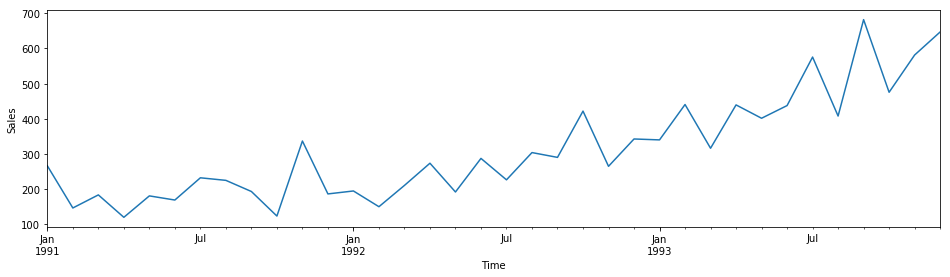

In [4]:
fig, ax = plt.subplots(1, figsize=plt.figaspect(.25))
s.plot(ax=ax)
ax.set(ylabel=s.name);

#### Comparing forecasting models

In [5]:
# split data into train, update and test
train = pd.Series([shampoo.iloc[0].iloc[:24]])
update = pd.Series([shampoo.iloc[0].iloc[:30]])
test = pd.Series([shampoo.iloc[0].iloc[30:]])
train.iloc[0].tail()

Time
1992-08    303.6
1992-09    289.9
1992-10    421.6
1992-11    264.5
1992-12    342.3
Freq: M, Name: Sales, dtype: float64

In [6]:
# specify forecasting horizon corresponding to the test period
fh = np.arange(7, 13)
test.iloc[0]

Time
1993-07    575.5
1993-08    407.6
1993-09    682.0
1993-10    475.3
1993-11    581.3
1993-12    646.9
Freq: M, Name: Sales, dtype: float64

In [7]:
# arima model
order = (3, 2, 1)
m = ARIMAForecaster(order=order)
m.fit(train)

# evaluate forecasts using default scorer (root mean squared error)
m.score(test, fh=fh)

197.12499933158503

In [8]:
# get forecasts
m.predict(fh=fh)

1993-07    360.799893
1993-08    392.708998
1993-09    378.297940
1993-10    404.737829
1993-11    393.037692
1993-12    414.144642
Freq: M, dtype: float64

In [9]:
# update forecasts using Kalman smoothing on updated data 
#  and forecasts obtained from previously fitted model
m.update(update)
m.score(test, fh=fh)

171.10956328122785

In [10]:
# compare with fitting the model directly on the full data
m = ARIMAForecaster(order=order)
m.fit(update)
extra_periods = len(update.iloc[0]) - len(train.iloc[0])
m.score(test, fh=fh - extra_periods)

146.96807856765895

In [11]:
# simple exponential smoothing
m = ExpSmoothingForecaster()
m.fit(train)
m.score(test, fh=fh)

270.2315281500116

#### Common hyper-parameter interface

In [12]:
# check set params interface
m.get_params()

{'check_input': True,
 'damped': False,
 'damping_slope': None,
 'optimized': True,
 'remove_bias': False,
 'seasonal': None,
 'seasonal_periods': None,
 'smoothing_level': None,
 'smoothing_seasonal': None,
 'smoothing_slope': None,
 'trend': None,
 'use_basinhopping': False,
 'use_boxcox': False}

In [13]:
# automatically fitted param
m._fitted_estimator.params['smoothing_level']

0.2813716099324507

In [14]:
m.set_params(**{'smoothing_level': .75})
m.fit(train)
m.score(test, fh=fh)

249.40758580842584

In [15]:
# user given fixed parameter
m._fitted_estimator.params['smoothing_level']

0.75

In [16]:
# naive 'dummy' forecaster, always predicting the last point
m = DummyForecaster(strategy='last')
m.fit(train)
m.predict(fh=fh)

1993-07    342.3
1993-08    342.3
1993-09    342.3
1993-10    342.3
1993-11    342.3
1993-12    342.3
Freq: M, dtype: float64

In [17]:
# always predicts mean of time series 
m.score(test, fh=fh)

238.61879640967095

In [18]:
# ensemble of forecasters
estimators = [
    ('ses', ExpSmoothingForecaster()), 
    ('holt', ExpSmoothingForecaster(trend='additive')), 
    ('damped', ExpSmoothingForecaster(trend='additive', damped=True))
]
m = EnsembleForecaster(estimators=estimators)
m.fit(train)
m.score(test, fh=fh)

242.3329755810865

### Forecasting with exogenous time series

In [19]:
# load multivariate data
X, y = load_longley(return_X_y=True)

# get data in required format
y_train = pd.Series([y.iloc[0].iloc[:13]])
y_test = pd.Series([y.iloc[0].iloc[13:]])

X_train = pd.DataFrame([pd.Series([X.iloc[0, i].iloc[:13]]) for i in range(X.shape[1])]).T
X_train.columns = X.columns
X_test = pd.DataFrame([pd.Series([X.iloc[0, i].iloc[13:]]) for i in range(X.shape[1])]).T
X_test.columns = X.columns

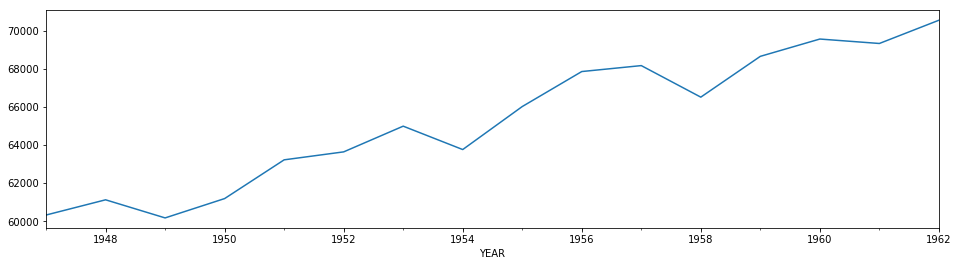

In [20]:
fig, ax = plt.subplots(1, figsize=plt.figaspect(.25))
s = y.iloc[0]
s.plot(ax=ax);

In [21]:
y_train.iloc[0].tail()

YEAR
1955    66019
1956    67857
1957    68169
1958    66513
1959    68655
Freq: A-DEC, Name: TOTEMP, dtype: int64

In [22]:
y_test.iloc[0]

YEAR
1960    69564
1961    69331
1962    70551
Freq: A-DEC, Name: TOTEMP, dtype: int64

In [23]:
# forecasting horizon for test period
fh = np.arange(y_test.iloc[0].shape[0]) + 1
fh

array([1, 2, 3])

Compare model performance with and without exogenous features

In [24]:
order = (3, 2, 1)

In [25]:
m = ARIMAForecaster(order=order)
m.fit(y_train, X=X_train)
m.predict(fh=fh, X=X_test)

1960    69459.894738
1961    68996.247410
1962    71092.492103
Freq: A-DEC, dtype: float64

In [26]:
m.score(y_test, X=X_test, fh=fh)

372.42936662335666

In [27]:
m = ARIMAForecaster(order=order)
m.fit(y_train)
m.score(y_test,fh=fh)

1400.8569388795754

## High-level interface
* Put data into expected format, i.e. nested pandas DataFrame
* Specify forecasting task 
* Use forecasting strategies

### Single series forecasting

In [28]:
# get data into expected nested format
shampoo = load_shampoo_sales(return_y_as_dataframe=True)
train = pd.DataFrame(pd.Series([shampoo.iloc[0, 0].iloc[:24]]), columns=shampoo.columns)
update = pd.DataFrame(pd.Series([shampoo.iloc[0, 0].iloc[:30]]), columns=shampoo.columns)
test = pd.DataFrame(pd.Series([shampoo.iloc[0, 0].iloc[30:]]), columns=shampoo.columns)

In [29]:
# create forecasting task specifying variable to be forecasted and forecasting horizon
task = ForecastingTask(target='ShampooSales', fh=[6, 7, 8], metadata=train)

In [30]:
# ARIMA forecasting strategy
estimator = ARIMAForecaster()
m = ForecastingStrategy(estimator=estimator)
m.fit(task, train)
m.predict()

1993-06    242.356876
1993-07    228.803899
1993-08    216.008826
Freq: M, dtype: float64

In [31]:
# update estimator with data up to point of prediction and predict again
m.update(update)
m.predict()

1993-06    378.858673
1993-07    412.939905
1993-08    389.847656
Freq: M, dtype: float64

In [32]:
# naive forecasting strategies
estimator = DummyForecaster(strategy='mean')
m = ForecastingStrategy(estimator=estimator)
m.fit(task, train)
m.predict()

1993-06    229.624945
1993-07    229.624945
1993-08    229.624945
Freq: M, dtype: float64

### Reduction strategies 
* Solving forecasting task with time-series regression algorithms using rolling window approach

In [33]:
# define simple time-series regressor using time-series as features
steps = [
    ('tabularise', Tabulariser()),
    ('clf', RandomForestRegressor(n_estimators=100))
]
estimator = Pipeline(steps)

task = ForecastingTask(target='ShampooSales', fh=[1, 2],
                       metadata=train)

s = Forecasting2TSRReductionStrategy(estimator=estimator)
s.fit(task, train)
y_pred = s.predict()
y_pred

1993-01    330.629
1993-02    348.947
Freq: M, Name: Sales, dtype: float64

In [34]:
test = update.iloc[0, 0][y_pred.index]
np.sqrt(mean_squared_error(test, y_pred)) 

64.9843606185368

In [35]:
# number of windows (number of rows)
s.rw.get_n_splits()

19

In [36]:
# window length (number of features)
s.window_length_

4

### Forecasting with exogenous time series

In [37]:
# get data into expected nested format
longley = load_longley(return_X_y=False)
train = pd.DataFrame([pd.Series([longley.iloc[0, i].iloc[:13]]) for i in range(longley.shape[1])]).T
train.columns = longley.columns

test = pd.DataFrame([pd.Series([longley.iloc[0, i].iloc[13:]]) for i in range(longley.shape[1])]).T
test.columns = longley.columns

In [38]:
train

,GNPDEFL,GNP,UNEMP,ARMED,POP,TOTEMP
0,YEAR 1947 83.0 1948 88.5 1949 88.2...,YEAR 1947 234289 1948 259426 1949 258...,YEAR 1947 2356 1948 2325 1949 3682 19...,YEAR 1947 1590 1948 1456 1949 1616 19...,YEAR 1947 107608 1948 108632 1949 109...,YEAR 1947 60323 1948 61122 1949 60171...


In [39]:
# create forecasting task specifying variable to be forecasted and forecasting horizon
task = ForecastingTask(target='TOTEMP', fh=[1, 2, 3], metadata=train)

In [40]:
# ARIMA forecasting strategy
estimator = ARIMAForecaster(order=order)
m = ForecastingStrategy(estimator=estimator)
m.fit(task, train)
m.predict(data=test)

1960    69459.894738
1961    68996.247410
1962    71092.492103
Freq: A-DEC, dtype: float64